# Figure 1: Study region, melt rates, sea ice velocity

In [1]:
import sys
sys.path.insert(0, '/g/data/gh9/wgh581/Python_code/plot_code/metroms_code')
import os
from netCDF4 import *
from numpy import *
import copy
import cmocean.cm as cmo
from matplotlib.pyplot import *
import matplotlib.gridspec as gridspec
from fxn_rotate_vector_cice import rotate_vector_cice
from fxn_rotate_vector_roms import rotate_vector_roms
import xarray as xr

In [2]:
# Degrees to radians conversion
deg2rad = pi/180.0
# Seconds per year conversion
sec_per_year = 365.25*24*3600

# Path
path = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/'
roms_grid = path + 'RAW/metroms_CONTROL/ocean_his_0042.nc'
roms_CNTR = 'ocean_climatology_CONTROL_2008_2011.nc'
roms_path = path + 'POST_PROCESS/' + roms_CNTR
cice_CNTR = 'cice_climatology_CONTROL_2008_2011.nc'
cice_path = path + 'POST_PROCESS/' + cice_CNTR

In [3]:
# Read the cice grid
print('Reading grid')
id = Dataset(cice_path, 'r')
aice_tmp = id.variables['aice'][:,:-15,:-1]
lon_cice = id.variables['TLON'][:-15,:-1]
lat_cice = id.variables['TLAT'][:-15,:-1]
angle_cice = id.variables['ANGLE'][:-15,:-1]
id.close()
aice = aice_tmp
aice_extmin = 0.15

# Convert to spherical coordinates
x_cice = -(lat_cice+90)*cos(lon_cice*deg2rad+pi/2)
y_cice = (lat_cice+90)*sin(lon_cice*deg2rad+pi/2)


# dim_cice = xr.open_dataset(file_path[0] + 'iceh.2010-01-05.nc')

Reading grid


In [5]:
np.shape(aice)

(4, 413, 1439)

In [7]:
# Read the ROMS grid
id   = Dataset(roms_grid, 'r')
lon  = id.variables['lon_rho'][:-15,:-1]
lat  = id.variables['lat_rho'][:-15,:-1]
h    = id.variables['h'][:-15,:-1]
zice = id.variables['zice'][:-15,:-1]
mask = id.variables['mask_rho'][:-15,:-1]
angle = id.variables['angle'][:-15,:-1]
id.close()

# Convert to spherical coordinates
x = -(lat+90)*cos(lon*deg2rad+pi/2)
y = (lat+90)*sin(lon*deg2rad+pi/2)

In [8]:
# Center of missing circle (metroms)
lat_c   = -83
lon_c   = 50
# Radius of missing circle (play around with this until it works)
radius  = 10.1
# Find center in spherical coordinates
x_c_metroms = -(lat_c+90)*np.cos(lon_c*deg2rad+np.pi/2)
y_c_metroms = (lat_c+90)*np.sin(lon_c*deg2rad+np.pi/2)
# Build a regular x-y grid and select the missing circle
lat_max = -63+90
x_reg, y_reg = np.meshgrid(np.linspace(-lat_max, lat_max, num=1000), \
                           np.linspace(-lat_max, lat_max, num=1000))
land_circle = np.zeros(np.shape(x_reg))
land_circle_metroms = np.ma.masked_where(np.sqrt((x_reg-x_c_metroms)**2 + \
                      (y_reg-y_c_metroms)**2) > radius, land_circle)

Load melt rate

In [24]:
id = Dataset(roms_path, 'r')
m_tmp = id.variables['m'][:,:-15,:-1]*sec_per_year
id.close()
for tt in range(4):
    m_tmp[tt,:,:] = ma.masked_where(zice==0, m_tmp[tt,:,:])
melt = m_tmp
melt_tmp = melt.mean(axis=0)

Load sea ice velocity

In [12]:
# Load sea ice motion (uvel, vvel)
id = Dataset(cice_path, 'r')
uvel_tmp = id.variables['uvel'][:,:-15,:-1]
vvel_tmp = id.variables['vvel'][:,:-15,:-1]
id.close()
# Rotate to lat/lon grid
uvel_tmp, vvel_tmp = rotate_vector_cice(uvel_tmp, vvel_tmp, angle_cice)
# Masking
uvel_tmp[aice < aice_extmin] = np.nan
vvel_tmp[aice < aice_extmin] = np.nan

uvel = uvel_tmp
vvel = vvel_tmp

Masking

In [13]:
# Masking
h    = ma.masked_where(mask==0, h)
h    = ma.masked_where(zice!=0, h)
zice = ma.masked_where(mask==0, zice)
zice = ma.masked_where(zice==0, zice)
lat  = ma.masked_where(mask==1, lat)

Plotting

In [14]:
ft_size = 14 
my_dpi = 150

# Region range
xlim_min = -25
xlim_max = 15
ylim_min = -30
ylim_max = 7

# Colormap
from palettable.scientific.diverging import Vik_19_r
from palettable.scientific.diverging import Vik_19

In [101]:
# To add longitude lines to plot
y_30SE = xlim_max * tan(60*deg2rad+pi/2)
y_60SE = xlim_max * tan(30*deg2rad+pi/2)

y_30NW = xlim_min * tan(60*deg2rad+pi/2)
y_60NW = xlim_min * tan(30*deg2rad+pi/2)

x_30NE = -ylim_max / tan(30*deg2rad+pi/2)

y_30SW = -xlim_min * tan(30*deg2rad+pi/2)

In [210]:
# To add latitude lines to plot (75S is not defined everywhere on model grid)
# Center (south pole)
lat_c   = -90
lon_c   = 0
# Find center in spherical coordinates
x_c_metroms_0 = -(lat_c+90)*np.cos(lon_c*deg2rad+np.pi/2)
y_c_metroms_0 = (lat_c+90)*np.sin(lon_c*deg2rad+np.pi/2)
# Build a regular x-y grid and select the missing circle
lat_max = -63+90
land_circle_tmp = np.zeros(np.shape(x_reg_tmp))
land_circle_75 = np.where(np.sqrt((x_reg_tmp-x_c_metroms_tmp)**2 + \
                      (y_reg_tmp-y_c_metroms_tmp)**2) > 15, land_circle_tmp, 1)

/jobfs/88751695.gadi-pbs/ipykernel_1566625/3264776054.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  SC_m = pcolormesh(x, y, melt_tmp, cmap=Vik_19.mpl_colormap, vmin=-5, vmax=5)


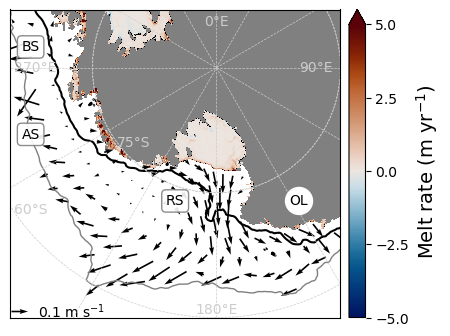

In [236]:
# New figure: one plot showing melt rates and sea ice motion vectors
fig = figure(figsize=(4.5,4))
bbox_props  = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
bbox_circle = {"boxstyle" : "circle", "color":"w"}

gs  = gridspec.GridSpec(1, 2, width_ratios=[1,0.05], wspace=0.05)

ax = fig.add_subplot(gs[0])
contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
contourf(x, y, lat, colors='0.5')
contourf(x, y, zice*1, colors='k')
SC_m = pcolormesh(x, y, melt_tmp, cmap=Vik_19.mpl_colormap, vmin=-5, vmax=5)
contour(x, y, h, levels=[1000], colors='k', linewidths=1.5)
contour(x_cice, y_cice, aice[2,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
ff = 19
Q = quiver(x_cice[::ff,::ff], y_cice[::ff,::ff], -uvel[2,::ff,::ff], -vvel[2,::ff,::ff], scale=2, width=0.005)
quiverkey(Q, 0.05, 0.125, 0.1, r'0.1 m s$^{-1}$', labelpos='E', coordinates='figure')
xlim(xlim_min, xlim_max)
ylim(ylim_min, ylim_max)
setp(ax.get_xticklabels(), visible=False)
setp(ax.get_yticklabels(), visible=False)
# Add labels
#text(-22.5, 0.5, 'BS', fontsize=ft_size-4, ha='center', va='center', bbox=bbox_props)
text(-22.5, 2.5, 'BS', fontsize=ft_size-4, ha='center', va='center', bbox=bbox_props)
text(-22.5, -8, 'AS', fontsize=ft_size-4, ha='center', va='center', bbox=bbox_props)
text(-5, -16, 'RS', fontsize=ft_size-4, ha='center', va='center', bbox=bbox_props)
text(10, -16, 'OL', fontsize=ft_size-4, ha='center', va='center', bbox=bbox_circle)
# Add longitude lines
plot([0, 0], [ylim_max, ylim_min], color='0.8', linewidth=0.5, linestyle='--')
plot([xlim_min, xlim_max], [0, 0], color='0.8', linewidth=0.5, linestyle='--')
# SE
plot([0, xlim_max], [0, y_30SE], color='0.8', linewidth=0.5, linestyle='--')
plot([0, xlim_max], [0, y_60SE], color='0.8', linewidth=0.5, linestyle='--')
# NW
plot([xlim_min, 0], [y_30NW, 0], color='0.8', linewidth=0.5, linestyle='--')
plot([xlim_min, 0], [y_60NW, 0], color='0.8', linewidth=0.5, linestyle='--')
# NE
plot([0, x_30NE], [0, ylim_max], color='0.8', linewidth=0.5, linestyle='--')
plot([0, xlim_max], [0, -1*y_30SE], color='0.8', linewidth=0.5, linestyle='--')
# SW
plot([xlim_min, 0], [-1*y_30SW, 0], color='0.8', linewidth=0.5, linestyle='--')
plot([xlim_min, 0], [-1*y_60SW, 0], color='0.8', linewidth=0.5, linestyle='--')
# Labels of longitude lines
text(0, ylim_min+1, '180°E', fontsize=ft_size-4, ha='center', va='center', color='0.8')
text(0, ylim_max-1.5, '0°E', fontsize=ft_size-4, ha='center', va='center', color='0.8')
text(xlim_max-3, 0, '90°E', fontsize=ft_size-4, ha='center', va='center', color='0.8')
text(xlim_min+3, 0, '270°E', fontsize=ft_size-4, ha='center', va='center', color='0.8')
# Add latitude lines
contour(x_cice, y_cice, lat_cice, levels=[-60], colors='0.8', linewidths=0.5, linestyles='--')
contour(x_reg, y_reg, land_circle_75, levels=1, colors='0.8', linewidths=0.5, linestyles='--')
# Labels of latitude lines
text(-10, -9, '75°S', fontsize=ft_size-4, ha='center', va='center', color='0.8')
text(-22.5, -17, '60°S', fontsize=ft_size-4, ha='center', va='center', color='0.8')

ax.tick_params(axis='both', which='both', length=0)
cbar_ax = fig.add_subplot(gs[1])
cbar = colorbar(SC_m, cax=cbar_ax, ticks=np.arange(-5, 7.5, 2.5), extend='max')
cbar.set_label('Melt rate (m yr$^{-1}$)', fontsize=ft_size)
subplots_adjust(left=0.01, right=0.8)

plot_flag = 1
if plot_flag == 1:
    fig_name = 'Figure1.png'
    fig_path = '/g/data/gh9/wgh581/Python_code/MetROMS_BasalMelt_Perturbation/figures/'
    savefig(fig_path + fig_name, dpi=my_dpi, bbox_inches='tight', facecolor='white')

In [234]:
pwd

'/home/581/wgh581'